In [105]:
import argparse
import config
import utils.utils as utils

import models.models as models
import dataloaders.dataloaders as dataloaders
import utils.utils as utils
import config
import torchvision.transforms as T
from PIL import Image
import torch
import numpy as np
import time
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser()
type(parser)
parser = config.add_all_arguments(parser, train=False)

## pass parameters to parser

In [2]:

opt = parser.parse_args("--dataset_mode ade20k --name oasis_ade20k_pretrained --dataroot data/ADEChallengeData2016/ --batch 1 --num_workers 4".split()) 
opt.phase = "test"
opt.continue_train = False
opt.add_vgg_loss = False
# utils.fix_seed(42)

## create dataloader to compare images further

In [40]:
#--- create dataloader ---#
_, dataloader_val = dataloaders.get_dataloaders(opt)

#--- create utils ---#
image_saver = utils.results_saver(opt)
 
#--- create models ---#
model = models.OASIS_model(opt).cuda()
#model = models.put_on_multi_gpus(model, opt)
model.eval()
#--- iterate over validation set ---#
for i, data_i in enumerate(dataloader_val):
    _, label = models.preprocess_input(opt, data_i)
    generated = model(None, label, "generate", None)
    image_saver(label, generated, data_i["name"])
    break


Created Ade20kDataset, size train: 2000, size val: 2000
Created OASIS_Generator with 74314691 parameters


/home/alexander/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/alexander/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/alexander/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/alexander/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/alexander/.local/lib/python3.8/site-packages/torch/nn/func

In [47]:
import torchvision.transforms as TR
print(f"Loading image {data_i['name'][0]}")
img = Image.open(f"data/ADEChallengeData2016/images/validation/{data_i['name'][0]}").convert("RGB")
img=TR.functional.to_tensor(img)
img = TR.functional.resize(img, (256, 256), Image.BICUBIC)
img = TR.functional.normalize(img, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)).cuda()



Loading image ADE_val_00000001.jpg


/home/alexander/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [48]:
model.netD = models.discriminators.OASIS_Discriminator(opt).cuda()
model.netD.load_state_dict(torch.load("checkpoints/oasis_ade20k_pretrained/models/best_D.pth"))
pool = torch.nn.MaxPool3d((151,1,1), stride=1, return_indices=True) # use pool and unpool for segmentation NMS, i didn't find another way to do this, so i created my own
unpool = torch.nn.MaxUnpool3d((151,1,1), stride=1)

In [55]:
labels = model.netD(img.unsqueeze(0))[0][1:].unsqueeze(0).cuda()
output,indices = pool(labels.unsqueeze(0))
output = output/output
unpooled_output = unpool(output,indices)
my_label = unpooled_output[0] # label from pretrained UNET

## Visualise generated images, in this example 5 images with different noise

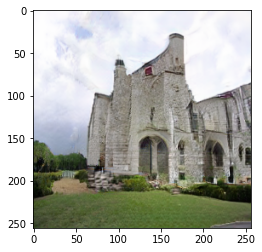

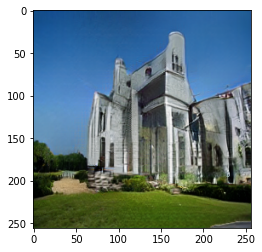

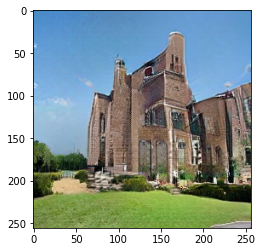

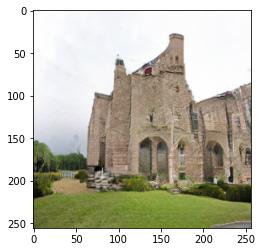

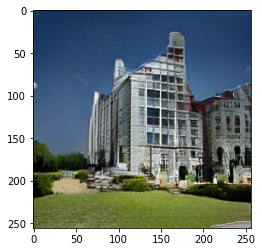

In [108]:
i = 0
cls = 151 # use cls = 151 if you want to change style of whole picture, if you want to change another class you should pick it's label
          # e.g. sky's label equals 3 for ADE dataset
shift = 0 # shift for noise, you can increase shift to visualise the region of your class
seed = 0 # start from 0 seed
gt = my_label # use label/my_label as GT/UNET label

for j in range(5):
	torch.manual_seed(seed)
	z = torch.randn(1, 64, dtype=torch.float32, device="cuda:0")
	z = z.view(1, 64, 1, 1)
	z = z.expand(1, 64, 256, 256)
	if cls==151:
		z = z + shift
	else:
		z = (z[0]+shift)*gt[i][cls] 
		z = z.unsqueeze(0)
	generated = model(None, gt[i].unsqueeze(0), "generate", None,z)

	im = utils.tens_to_lab(gt[i], 150)
	im = utils.tens_to_im(generated[0]) * 255
	image = Image.fromarray(np.uint8(im))
	plt.figure()
	plt.imshow(image)
	# image.save(f"check/image{seed}.jpg")
	seed+=1